# Multi layer perceptron neural network with MNIST

MNIST is a dataset of handwriten digits - images of the digits and their labels. MNIST classification is also used as so called "Hello world" of machine learning. The dataset is already part of Keras, the machine learning framework we are going to use in our workshop.

Lets do the import first and load the dataset.

We will get:
- training images collection that consist of three dimensional array (index * row * column) of images representation
- training labels that represents the ground thruth of the training images [0, 1, 5, 8, 2, 0...], based on index
- testing images collection for validation. It's same but smaller
- testing labels is same collection as training labels, but again, smaller and used for validation of trianed model

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
import random
%matplotlib inline

# load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(train_images))
print("The MNIST database has a test set of %d examples." % len(test_images))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


We can plot some random samples from the dataset, to see how they are looking. You can run the cell multiple times to see different images

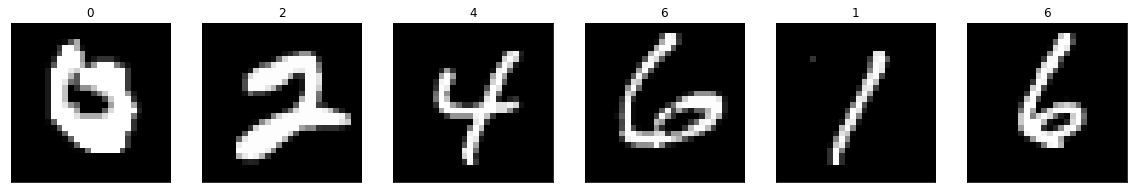

In [11]:
# plot first six training images
fig = plt.figure(figsize=(20, 20))
for i in range(6):
    sample_index = random.randint(0, len(train_images))
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])  # position of specific graph
    ax.imshow(train_images[sample_index], cmap='gray')  # display image
    ax.set_title(str(train_labels[sample_index]))  # label over image

We can also plot the detailed sample image, to see exact pixel values - these are our data which we are going to use for training, and we need to understand how they are structured

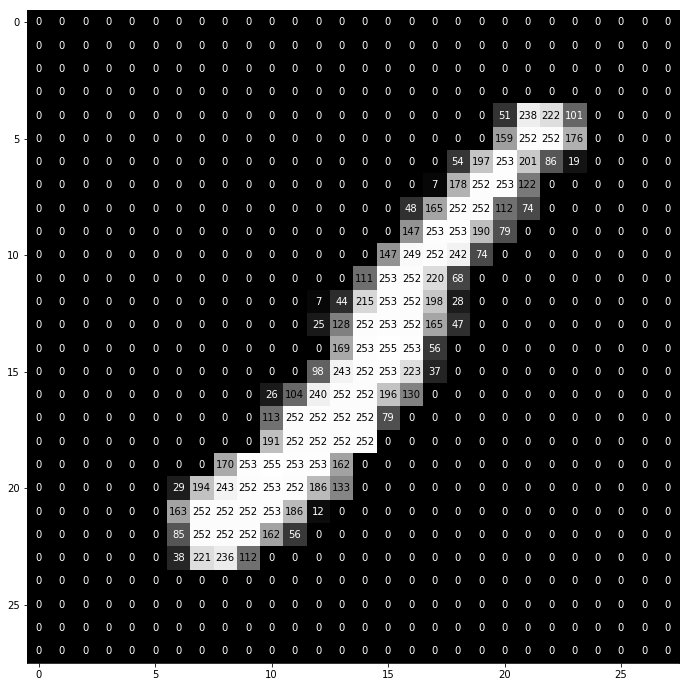

In [12]:
sample_index = random.randint(0, len(train_images))
# plot detailed sample
img = train_images[sample_index]
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        ax.annotate(str(round(img[x][y], 2)), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')

To be able to process the dataset with a standard Dense layer, we will need to flatten the image - as it is 28x28 pixels. So the idea is to take the input 2d array and have it as 1d array. 

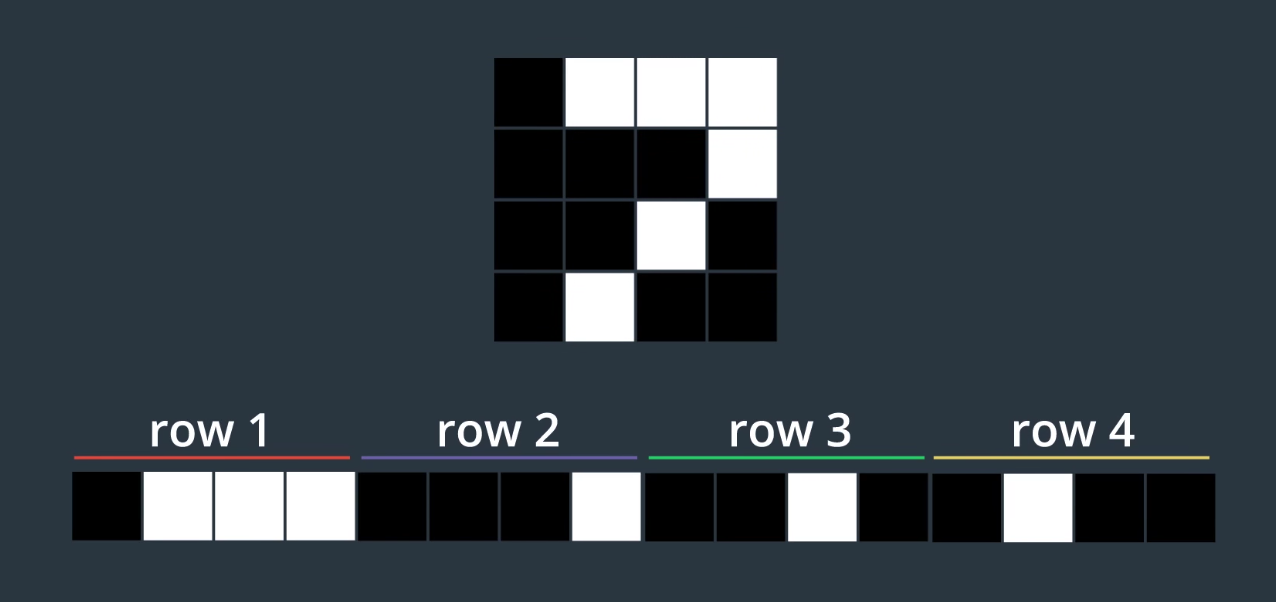

Each neuron in the first layer will have connections to all the pixels in the array. Then our network will look something like this (except more layers):

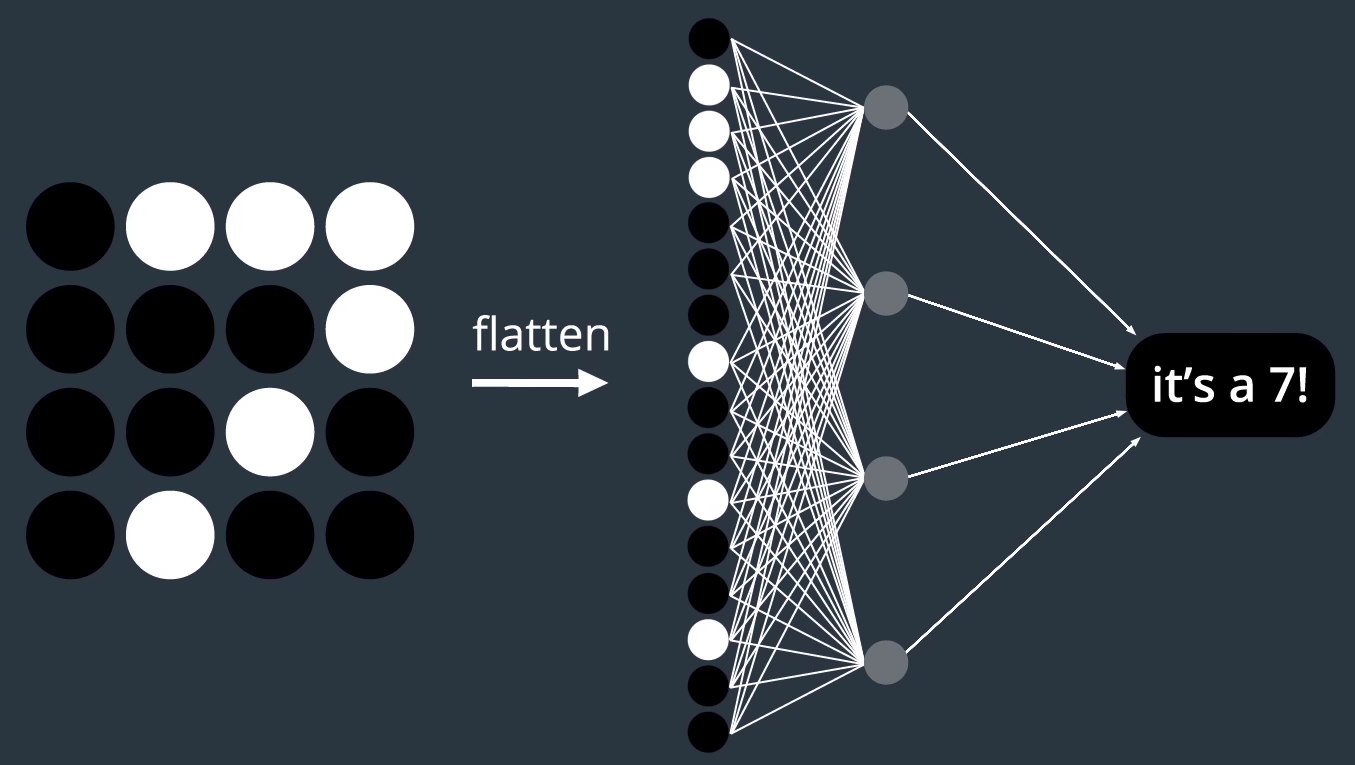


### Rescale
Images are stored in <0, 255> range represnation of single color. It's convient to keep all values in the neural netowrk in <0, 1> interval.
We will divide every number by 255 to get the desired format.

In [13]:
scaled_train_images = train_images.astype('float32') / 255
scaled_test_images = test_images.astype('float32') / 255

### One hot encode
Mnist dataset labels comes as [0, 2, 3, 1... ] labels. But our neural network will have ten perceptrons in the last layer - each one will be doing a prediction for a specific number. To be able to train this neural network on our dataset, we need to do so called one-hot encoding of the labels - transform each label into a sparse 1d array, which will have everywhere zeroes, except one for the label.

In [14]:
from keras.utils import np_utils

print('Integer-valued labels:')
print(train_labels[:10])

# one-hot encode the labels
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(test_labels[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Define the model
We are using simple model with only simple Dense hidden layers and rmsprop as optimizer.

In [15]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# define the model
K.clear_session()  # multiple runs of this cell could append layers to already allocated model
model = Sequential()
model.add(Flatten(input_shape=scaled_train_images.shape[1:]))  # 28 x 28 shape of the image as input shape
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# summarize the model
model.summary()

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Training
We are using scaled training images for the training and checkpoiting our weights to he `mnist.model.best.hdf5` file. Those weights can be later on load using `model.load()` function.

In [16]:
from keras.callbacks import ModelCheckpoint

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(scaled_train_images, train_labels, batch_size=128, epochs=10,
                 validation_split=0.2, callbacks=[checkpointer],
                 verbose=1, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 7s 152us/step - loss: 0.2762 - acc: 0.9141 - val_loss: 0.1238 - val_acc: 0.9618

Epoch 00001: val_loss improved from inf to 0.12384, saving model to mnist.model.best.hdf5
Epoch 2/10
48000/48000 [==============================] - 6s 134us/step - loss: 0.1119 - acc: 0.9662 - val_loss: 0.1034 - val_acc: 0.9699

Epoch 00002: val_loss improved from 0.12384 to 0.10343, saving model to mnist.model.best.hdf5
Epoch 3/10
48000/48000 [==============================] - 7s 141us/step - loss: 0.0792 - acc: 0.9764 - val_loss: 0.0816 - val_acc: 0.9770

Epoch 00003: val_loss improved from 0.10343 to 0.08158, saving model to mnist.model.best.hdf5
Epoch 4/10
48000/48000 [==============================] - 7s 144us/step - loss: 0.0631 - acc: 0.9808 - val_loss: 0.0901 - val_acc: 0.9768

Epoch 00004: val_loss did not improve from 0.08158
Epoch 5/10
48000/48000 [==============================] - 6s 129u

### Evaluate the model
We will evaluate the trained model against the testing dataset, that the model didn't saw yet.

In [18]:
from keras.models import load_model

model = load_model('mnist.model.best.hdf5')

score = model.evaluate(scaled_test_images, test_labels, verbose=0)
accuracy = 100 * score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 97.9600%


### Sample predictions

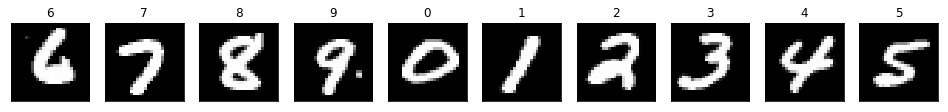

In [19]:
import numpy as np

start = random.randint(0, len(test_images) - 10)
end = start + 10
fig = plt.figure(figsize=(20, 20))

for i in range(end-start):
    display_image = test_images[start + i]
    prediction = int(model.predict(np.expand_dims(display_image, axis=0)).argmax())
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(display_image, cmap='gray')
    ax.set_title(str(prediction))

## Your tasks

Now here are tasks that you should do to get a little more familiar with this example:
1. Try changing the parameters of two Dense layers in the neural network - put there smaller sizes and see its effects
2. Remove the dropout layers from the dense network and assess how much they affect the network performance
3. Try to "cripple" the network as much as you can, to have for example accuracy around 50%. This is actually not a simple task, because we have such a dataset.